## POS tagging using modified Viterbi

In [1]:
#Importing libraries
import nltk
nltk.download('universal_tagset')
import random
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\AnindyaSudhir\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


### Data Preparation

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
print(nltk_data[:3])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [3]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:3])

3718
196
[[('But', 'CONJ'), ('with', 'ADP'), ('the', 'DET'), ('index', 'NOUN'), ('proving', 'VERB'), ('somewhat', 'ADV'), ('better', 'ADJ'), ('than', 'ADP'), ('*', 'X'), ('expected', 'VERB'), ('and', 'CONJ'), ('the', 'DET'), ('widely', 'ADV'), ('anticipated', 'VERB'), ('report', 'NOUN'), ('on', 'ADP'), ('October', 'NOUN'), ('employment', 'NOUN'), ('scheduled', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('arrive', 'VERB'), ('tomorrow', 'NOUN'), (',', '.'), ('stock', 'NOUN'), ('prices', 'NOUN'), ('firmed', 'VERB'), ('only', 'ADV'), ('modestly', 'ADV'), ('in', 'ADP'), ('response', 'NOUN'), ('to', 'PRT'), ('the', 'DET'), ('report', 'NOUN'), ('and', 'CONJ'), ('then', 'ADV'), ('faltered', 'VERB'), ('.', '.')], [('Close', 'ADJ'), ('parallels', 'NOUN'), ('between', 'ADP'), ('tests', 'NOUN'), ('and', 'CONJ'), ('practice', 'NOUN'), ('tests', 'NOUN'), ('are', 'VERB'), ('common', 'ADJ'), (',', '.'), ('some', 'DET'), ('educators', 'NOUN'), ('and', 'CONJ'), ('researchers', 'NOUN'), ('say', 'VERB'), ('0',

In [4]:
# Getting list of train tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95823

In [5]:
train_tagged_words[0:5]

[('But', 'CONJ'),
 ('with', 'ADP'),
 ('the', 'DET'),
 ('index', 'NOUN'),
 ('proving', 'VERB')]

In [6]:
# tokens 
train_tokens = [pair[0] for pair in train_tagged_words]
train_tokens[:10]

['But',
 'with',
 'the',
 'index',
 'proving',
 'somewhat',
 'better',
 'than',
 '*',
 'expected']

In [7]:
# vocabulary
train_vocabulary = set(train_tokens)
print(len(train_vocabulary))

12115


In [8]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [9]:
print(T)

{'CONJ', 'X', 'NOUN', 'VERB', 'ADJ', 'PRT', '.', 'ADP', 'NUM', 'DET', 'PRON', 'ADV'}


    Universal Part-of-Speech Tagset

    Tag 	Meaning 	English Examples
    ADJ 	adjective 	new, good, high, special, big, local
    ADP 	adposition 	on, of, at, with, by, into, under
    ADV 	adverb 	really, already, still, early, now
    CONJ 	conjunction 	and, or, but, if, while, although
    DET 	determiner, article 	the, a, some, most, every, no, which
    NOUN 	noun 	year, home, costs, time, Africa
    NUM 	numeral 	twenty-four, fourth, 1991, 14:24
    PRT 	particle 	at, on, out, over per, that, up, with
    PRON 	pronoun 	he, their, her, its, my, I, us
    VERB 	verb 	is, say, told, given, playing, would
    . 	punctuation marks 	. , ; !
    X 	other 	ersatz, esprit, dunno, gr8, univeristy

### Build the vanilla Viterbi based POS tagger

In [10]:
# computing P(w/t) and storing in T x V matrix
len_t = len(T)
len_v = len(train_vocabulary)
w_given_t = np.zeros((len_t, len_v))

In [11]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [12]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [13]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [14]:
tags_matrix

array([[4.62107215e-04, 8.31792969e-03, 3.48890930e-01, 1.56654343e-01,
        1.16913125e-01, 4.62107221e-03, 3.51201482e-02, 5.36044352e-02,
        4.11275402e-02, 1.21072091e-01, 5.82255088e-02, 5.49907573e-02],
       [1.08108111e-02, 7.50397444e-02, 6.15262315e-02, 2.05246419e-01,
        1.78060420e-02, 1.84101745e-01, 1.63116053e-01, 1.43402219e-01,
        2.86168512e-03, 5.56438789e-02, 5.45310006e-02, 2.59141494e-02],
       [4.27359752e-02, 2.91944239e-02, 2.64460713e-01, 1.46518141e-01,
        1.21946782e-02, 4.40464504e-02, 2.39889339e-01, 1.76440611e-01,
        9.53732990e-03, 1.33959446e-02, 4.80506709e-03, 1.67813338e-02],
       [5.51071111e-03, 2.17556655e-01, 1.10679910e-01, 1.68270722e-01,
        6.51195273e-02, 3.08910273e-02, 3.56255807e-02, 9.12760049e-02,
        2.33623106e-02, 1.34430304e-01, 3.57808135e-02, 8.14964324e-02],
       [1.68603696e-02, 2.09526923e-02, 6.97986603e-01, 1.19495830e-02,
        6.72777891e-02, 1.08037321e-02, 6.49860874e-02, 7.72

In [15]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [16]:
tags_df

,CONJ,X,NOUN,VERB,ADJ,PRT,.,ADP,NUM,DET,PRON,ADV
CONJ,0.000462,0.008318,0.348891,0.156654,0.116913,0.004621,0.035120,0.053604,0.041128,0.121072,0.058226,0.054991
X,0.010811,0.075040,0.061526,0.205246,0.017806,0.184102,0.163116,0.143402,0.002862,0.055644,0.054531,0.025914
NOUN,0.042736,0.029194,0.264461,0.146518,0.012195,0.044046,0.239889,0.176441,0.009537,0.013396,0.004805,0.016781
VERB,0.005511,0.217557,0.110680,0.168271,0.065120,0.030891,0.035626,0.091276,0.023362,0.134430,0.035781,0.081496
ADJ,0.016860,0.020953,0.697987,0.011950,0.067278,0.010804,0.064986,0.077263,0.021280,0.005074,0.000655,0.004911
PRT,0.001963,0.013416,0.249346,0.399869,0.083770,0.001636,0.042866,0.020615,0.057264,0.102421,0.016688,0.010144
.,0.057922,0.027168,0.220210,0.088945,0.044921,0.002511,0.092890,0.091186,0.080965,0.173944,0.065902,0.053349
ADP,0.000747,0.034277,0.320555,0.008222,0.107314,0.001495,0.039829,0.016978,0.063428,0.324613,0.068873,0.013668
NUM,0.014151,0.209316,0.354068,0.018278,0.033314,0.027123,0.117630,0.035083,0.183373,0.003243,0.001474,0.002948
DET,0.000481,0.045891,0.638155,0.040365,0.204829,0.000240,0.017540,0.009370,0.021624,0.005646,0.003604,0.012254


In [17]:
tags_df.loc['.', :]

CONJ    0.057922
X       0.027168
NOUN    0.220210
VERB    0.088945
ADJ     0.044921
PRT     0.002511
.       0.092890
ADP     0.091186
NUM     0.080965
DET     0.173944
PRON    0.065902
ADV     0.053349
Name: ., dtype: float32

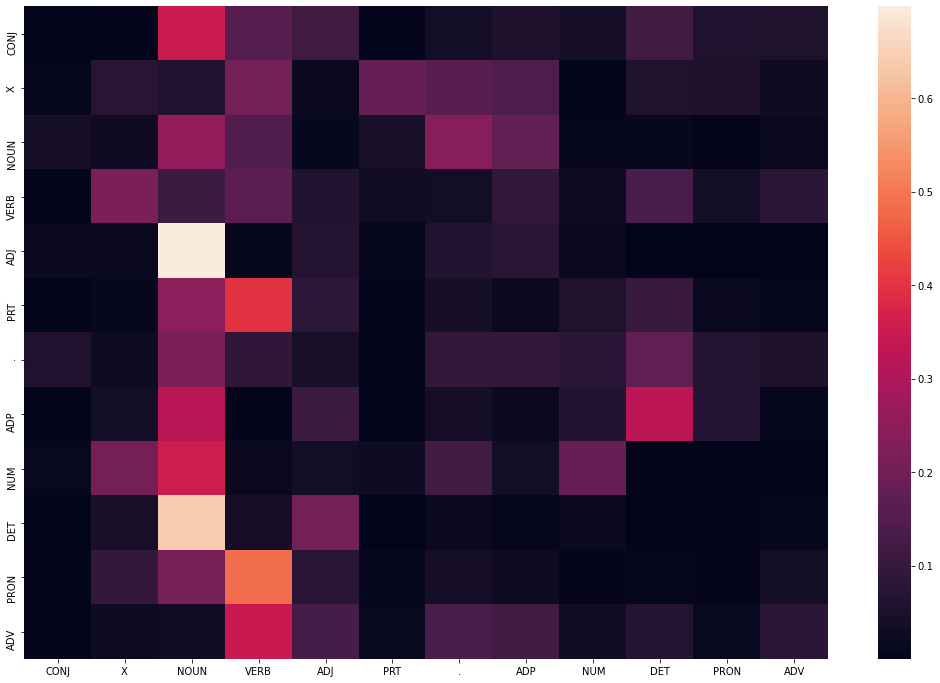

In [18]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

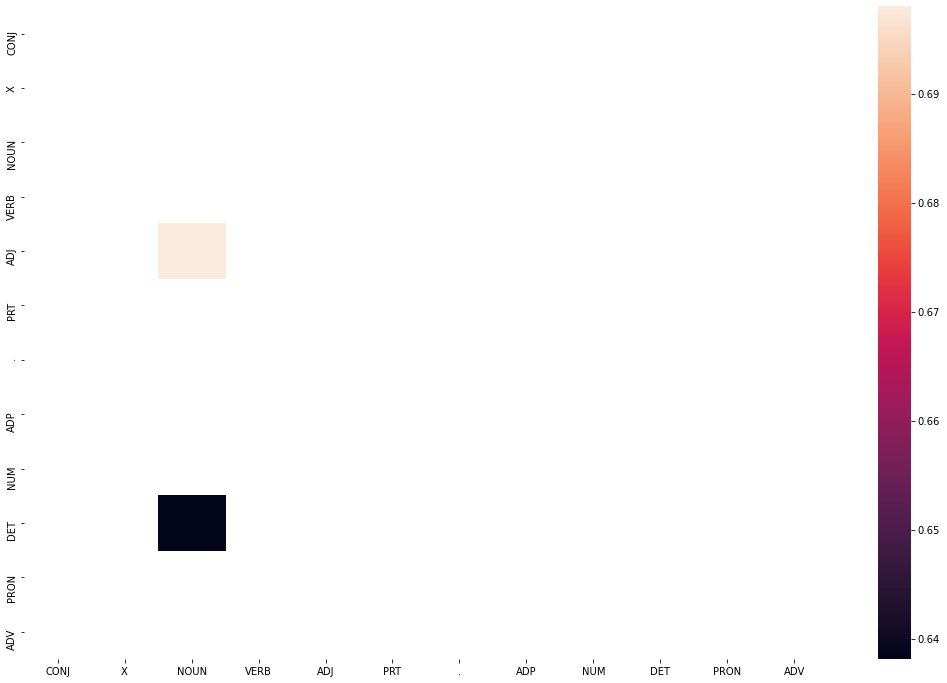

In [19]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Vanilla Viterbi Algorithm based POS Tagger

In [20]:
len(train_tagged_words)

95823

In [21]:
# Viterbi Heuristic
def Vanilla_Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Evaluation on Test Set

In [22]:
# Getting list of train tagged words

# list of test tagged words
test_run_base = [tup for sent in test_set for tup in sent]

# list of test untagged words
test_tagged_words = [tup[0] for sent in test_set for tup in sent]


In [23]:
# tagging the test sentences
start = time.time()
tagged_seq = Vanilla_Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [24]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  1660.8183443546295
[('The', 'DET'), ('sad', 'CONJ'), ('reality', 'NOUN'), ('is', 'VERB'), ('that', 'ADP'), ('the', 'DET'), ('retail', 'ADJ'), ('investor', 'NOUN'), ('continues', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('pursue', 'VERB'), ('stellar', 'ADJ'), ('performers', 'CONJ'), ('first', 'ADJ'), (',', '.'), ('while', 'ADP'), ('*-2', 'X'), ('leaving', 'VERB'), ('institutions', 'NOUN'), ('to', 'PRT'), ('grapple', 'CONJ'), ('with', 'ADP'), ('basis', 'NOUN'), ('points', 'NOUN'), ('of', 'ADP'), ('performance', 'NOUN'), ('on', 'ADP'), ('large', 'ADJ'), ('sums', 'NOUN'), ('of', 'ADP'), ('money', 'NOUN'), ('quarter', 'NOUN'), ('by', 'ADP'), ('quarter', 'NOUN'), ('*PPA*-3', 'X'), ('.', '.'), ('Fees', 'NOUN'), ('1', 'NUM'), ('7\\/8', 'NUM'), ('.', '.'), ('Money', 'NOUN'), ('managers', 'NOUN'), ('ranked', 'CONJ'), ('IBM', 'NOUN'), ("'s", 'PRT'), ('offering', 'VERB'), ('as', 'ADP'), ('the', 'DET'), ('most', 'ADJ'), ('significant', 'ADJ'), ('investment-grade', 'ADJ'), ('sal

In [25]:
# Let's check the accuracy of the vanilla viterbi algorithm

check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]

vanilla_viterbi_accuracy = len(check)/len(tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm is -", vanilla_viterbi_accuracy)

The accuracy of the Vanilla Viterbi Algorithm is - 0.911395013393777


In [26]:
#we got around 10% incorrect predictions. So, lets print those and try to understand the reason
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
print(len(incorrect_tagged_cases))
incorrect_tagged_cases

430


[[('The', 'DET'), (('sad', 'CONJ'), ('sad', 'ADJ'))],
 [('stellar', 'ADJ'), (('performers', 'CONJ'), ('performers', 'NOUN'))],
 [('performers', 'NOUN'), (('first', 'ADJ'), ('first', 'ADV'))],
 [('to', 'PRT'), (('grapple', 'CONJ'), ('grapple', 'VERB'))],
 [('managers', 'NOUN'), (('ranked', 'CONJ'), ('ranked', 'VERB'))],
 [("'s", 'PRT'), (('offering', 'VERB'), ('offering', 'NOUN'))],
 [('the', 'DET'), (('most', 'ADJ'), ('most', 'ADV'))],
 [('are', 'VERB'), (('infrequent', 'CONJ'), ('infrequent', 'ADJ'))],
 [('already', 'ADV'), (('6.5', 'CONJ'), ('6.5', 'NUM'))],
 [('could', 'VERB'), (('drop', 'NOUN'), ('drop', 'VERB'))],
 [('is', 'VERB'), (('slowed', 'CONJ'), ('slowed', 'VERB'))],
 [('a', 'DET'), (('double-A', 'CONJ'), ('double-A', 'ADJ'))],
 [('a', 'DET'), (('spread', 'VERB'), ('spread', 'NOUN'))],
 [('%', 'NOUN'), (('bellwether', 'CONJ'), ('bellwether', 'NOUN'))],
 [('a', 'DET'), (('sheaf', 'CONJ'), ('sheaf', 'NOUN'))],
 [('can', 'VERB'), (('trust', 'NOUN'), ('trust', 'VERB'))],
 [('ne

#### By this point, we have successfully implemented Vanilla Viterbi algorithm and now we have to look at and understand the unknown words problem and write modified Viterbi algorithms to fix the wrong predictions due to unknown words. For this, first print all unknown words:-

In [27]:
# Unknown words 

test_vocabulary = set([t for t in test_tagged_words])

unknown_words = list(test_vocabulary - train_vocabulary)
print("Total Unknown words :", len(unknown_words))
print("\n")
print("Unknown Words :", unknown_words)

Total Unknown words : 293


Unknown Words : ['allies', 'predispose', 'harmful', '28.53', 'approves', 'phase', 'essays', 'insistence', 'Offering', 'infrequent', 'test-prep', 'driver', 'despised', 'Red-blooded', 'longest', 'borrowings', 'urging', 'Chadha', 'experiencing', 'clearing', 'Guarantee', 'hard-hitting', 'liberty', 'participant', 'Wilfred', 'near-record', 'Corrigan', 'envoy', 'how-to', 'Monticello', 'Bramalea', 'spreads', 'Rail', 'travel-related', '*T*-143', 'leeway', 'wield', 'Sebastian', 'sounding', 'quotations', 'abortions', 'double-A', 'Sidak', 'lobbies', 'derivative', 'frenzy', '*T*-244', 'Sloan', 'entangled', 'Destinations', 'consequence', 'climb', 'happens', 'depends', '14-hour', 'drinks', 'pennies', 'gallium', 'revival', 'breakfast', '*T*-188', 'vetoes', 'responses', 'angered', '6.4', 'index-related', 'Sable', 'Clemens', 'Show', 'creditworthiness', 'adapting', 'nurtured', 'altering', 'brilliantly', 'headcount-control', 'overstated', 'delivering', 'Ratner', 'reshaping', 'P

### Lexicon and Rule-Based Models for POS Tagging.
#### Before we start modifying the Vanilla viterbi algorithm to improve the model, let's check how basic Lexical techniques like Unigram, bigram and trigram taggers which come out of box from NLTK libraries. 
## Note that this analysis is just to check how these techniques compare to probabilistic technique like HMM+Viterbi

#### Unigram Tagger

In [28]:
# Unigram Tagger
default_tagger = nltk.DefaultTagger('NOUN')
unigram_tagger = nltk.UnigramTagger(train_set, backoff = default_tagger)
unigram_tagger_accuracy = unigram_tagger.evaluate(test_set)
print("The accuracy of the Unigram Tagger is -", unigram_tagger_accuracy)

The accuracy of the Unigram Tagger is - 0.9383886255924171


In [29]:
# Bigram tagger

bigram_tagger = nltk.BigramTagger(train_set, backoff = unigram_tagger)
bigram_tagger.evaluate(test_set)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
print("The accuracy of the Bigram Tagger backed up by the rule_based_unigram_tagger is -", accuracy_bigram_tagger)

The accuracy of the Bigram Tagger backed up by the rule_based_unigram_tagger is - 0.9410673810014424


In [30]:
# trigram tagger

trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
trigram_tagger.evaluate(test_set)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)
print("The accuracy of the Trigram Tagger backed up by the bigram_tagger is -", accuracy_trigram_tagger)

The accuracy of the Trigram Tagger backed up by the bigram_tagger is - 0.9420976715433752


#### As we can see that simple lexical techniques are actually not as bad as we thought. They ran pretty fast and gave accuracy(94.20) more than Vanilla viterbi (91.13%).

## Solve the problem of unknown words

## Method 1 - Laplace Smoothing of emission probabilities for unknown words

Vanilla Viterbi algorithm's accuracy was around 91%. Some accuracy was lost because of emission probability of unknown words is 0. So, state probability of the word becomes 0 as state_probability = emission_p * transition_p. 
The solution to it can be Laplace smoothing in which we will assign a close to 0 value to, say 0.0000001, to emission probability so that the probability is not 0 in case of unknown words.

In [31]:
# Modified Viterbi algorithm - laplace smoothing
def Viterbi_with_Laplace_Smoothing(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # modification to the vanilla viterbi algorithm 
            # to consider unknown words
            if word not in train_vocabulary:
                #laplace smoothing
                emission_p = 0.0000001
            
            state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [32]:
# tagging the test sentences
laplace_unknown_word_tagged_seq = Viterbi_with_Laplace_Smoothing(test_tagged_words)

# accuracy
laplace_unknown_word_check = [i for i, j in zip(laplace_unknown_word_tagged_seq, test_run_base) if i == j]

laplace_viterbi_accuracy = len(laplace_unknown_word_check)/len(laplace_unknown_word_tagged_seq)

print("The accuracy of the Modified Viterbi Algorithm with laplace smoothening unknown words is -", laplace_viterbi_accuracy)

The accuracy of the Modified Viterbi Algorithm with laplace smoothening unknown words is - 0.9425097877601484


We can see that the viterbi algorithm with Laplace smoothing has better performance than the vanilla viterbi algorithm. The viterbi algorithm with Laplace smoothing achieves an accuracy of around 94.25% comapred to 91.13% of the vanilla viterbi.

## Method 2 -  Modified Viterbi with Rule based tagger for unknown words

#### Let's first write some rules for unknown words and see how accurately our morphological rules are able to predict unknown words
### Approach to the problem:-
    1. Separate out unknown words and write rule based regex tagger and test accuracy on unknown words.
    2. This helps in speeding up the rule writing process and we can keep comparing accuracies for different rules which we write. 
    3. We will use the rules created from this exercise in our viterbi algorithim to modify it such that it gives us better predictions.

In [33]:
#Creating a separate test set for unknown words to test and write our rules and then comparing accuracies
unknown_test_set = list(set([tuple for tuple in test_run_base if tuple[0] in unknown_words]))
unknown_test_set

[('belfries', 'NOUN'),
 ('bellwether', 'NOUN'),
 ('Red-blooded', 'ADJ'),
 ('451', 'NUM'),
 ('derivative', 'ADJ'),
 ('adapting', 'VERB'),
 ('Sloan', 'NOUN'),
 ('disseminating', 'VERB'),
 ('INS', 'NOUN'),
 ('three-lawyer', 'ADJ'),
 ('Cluff', 'NOUN'),
 ('Judicial', 'NOUN'),
 ('car-safety', 'ADJ'),
 ('robotic', 'ADJ'),
 ('W.N.', 'NOUN'),
 ('disasters', 'NOUN'),
 ('Leighton', 'NOUN'),
 ('lobbyist', 'NOUN'),
 ('semesters', 'NOUN'),
 ('band-wagon', 'ADJ'),
 ('acceded', 'VERB'),
 ('participant', 'NOUN'),
 ('payable', 'ADJ'),
 ('longest', 'ADJ'),
 ('*T*-177', 'X'),
 ('Used', 'VERB'),
 ('Mulford', 'NOUN'),
 ('Dynamics', 'NOUN'),
 ('Monticello', 'NOUN'),
 ('envoy', 'NOUN'),
 ('Offering', 'VERB'),
 ('clearing', 'VERB'),
 ('computer-aided', 'ADJ'),
 ('insistence', 'NOUN'),
 ('arsenide', 'NOUN'),
 ('composting', 'NOUN'),
 ('instructed', 'VERB'),
 ('Party', 'NOUN'),
 ('when-issued', 'ADJ'),
 ('Property\\/casualty', 'NOUN'),
 ('leery', 'ADJ'),
 ('Journals', 'NOUN'),
 ('sometimes-exhausting', 'ADJ'),
 

In [34]:
#There are 652 unknown words. Let's do some EDA on these unknown words. 
#    1. There are many numbers which have come up in the unknown words list. So we will write few regex rules specifically for such special cases to tag them. Any word containing number -> NUM tag
#    2. Check suffix like 'ous', 'ing', 'lly' etc to write regex rules to predict probable pos tag

rules = [
    (r'[a-zA-Z]+(es)$', 'NOUN'),   
    (r'[aA-zZ]+(ed|ing|ise|ate|fy|en)$', 'VERB'),

    (r'.+(ness|ers|ment|town|tion|sion|er|age|ance|ence|ism|ship)$', 'NOUN'),
    (r'.+(ly|how|way|wards|over)$', 'ADV'),    
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.+(able|ful|ous|ant|ic|ive|al|ent|less|ian)$', 'ADJ'),   
    
    (r'[0-9]+','NUM'),
    (r'^[aA-zZ].*[0-9]+','NOUN'),    
    (r'.*\'s$', 'NOUN'),  
    (r'.*s$', 'NOUN'),
    (r'^(0|([*|-|$].*))','X'), 
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), 
    (r'[0-9].?[,\/]?[0-9]*','NUM'), 
        
    (r'.*', 'NOUN')
    ]

In [35]:
#rule based tagger for predicting tags of unknown words
rule_based_tagger = nltk.RegexpTagger(rules)
predicted_unknown_seq = rule_based_tagger.tag([word[0] for word in unknown_test_set])

In [36]:
#calculating accuracy of our rule based tagger on unknown words. 
unknown_regex_check = [i for i, j in zip(predicted_unknown_seq, unknown_test_set) if i == j]

unknown_words_regex_accuracy = len(unknown_regex_check)/len(predicted_unknown_seq)

print("The accuracy of the unknown words after applying regex rules is -", unknown_words_regex_accuracy)

The accuracy of the unknown words after applying regex rules is - 0.7380952380952381


In [37]:
#printing all unknown words sets which were wrongly predicted
[(i,j) for i, j in zip(predicted_unknown_seq, unknown_test_set) if i != j]

[(('three-lawyer', 'NOUN'), ('three-lawyer', 'ADJ')),
 (('Judicial', 'ADJ'), ('Judicial', 'NOUN')),
 (('participant', 'ADJ'), ('participant', 'NOUN')),
 (('longest', 'NOUN'), ('longest', 'ADJ')),
 (('composting', 'VERB'), ('composting', 'NOUN')),
 (('leery', 'NOUN'), ('leery', 'ADJ')),
 (('Chinese-American', 'ADJ'), ('Chinese-American', 'NOUN')),
 (('mend', 'NOUN'), ('mend', 'VERB')),
 (('black-and-white', 'NOUN'), ('black-and-white', 'ADJ')),
 (('adequate', 'VERB'), ('adequate', 'ADJ')),
 (('intend', 'NOUN'), ('intend', 'VERB')),
 (('zip', 'NOUN'), ('zip', 'VERB')),
 (('everyday', 'NOUN'), ('everyday', 'ADJ')),
 (('prefer', 'NOUN'), ('prefer', 'VERB')),
 (('fragile', 'NOUN'), ('fragile', 'ADJ')),
 (('leeway', 'ADV'), ('leeway', 'NOUN')),
 (('mutual-fund', 'ADJ'), ('mutual-fund', 'NOUN')),
 (('bickering', 'VERB'), ('bickering', 'NOUN')),
 (('constitutional-law', 'ADJ'), ('constitutional-law', 'NOUN')),
 (('Iran-Contra', 'ADJ'), ('Iran-Contra', 'NOUN')),
 (('credit-rating', 'ADJ'), ('cr

### We are able to write many rules and bring up the accuracy on unknown words to ~73% just from these rules. We are still getting many inaccurate predictions but that is the limitation of Morphological rule based taggers

In [38]:
# rule based tagger.

def rule_based_tagger(word, train_set = train_set):
    
    rules = [
    (r'[a-zA-Z]+(es)$', 'NOUN'),   
    (r'[aA-zZ]+(ed|ing|ise|ate|fy|en)$', 'VERB'),

    (r'.+(ness|ers|ment|town|tion|sion|er|age|ance|ence|ism|ship)$', 'NOUN'),
    (r'.+(ly|how|way|wards|over)$', 'ADV'),    
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.+(able|ful|ous|ant|ic|ive|al|ent|less|ian)$', 'ADJ'),   
    
    (r'[0-9]+','NUM'),
    (r'^[aA-zZ].*[0-9]+','NOUN'),    
    (r'.*\'s$', 'NOUN'),  
    (r'.*s$', 'NOUN'),
    (r'^(0|([*|-|$].*))','X'), 
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), 
    (r'[0-9].?[,\/]?[0-9]*','NUM'), 
        
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(rules)
    
    return regex_based_tagger.tag_sents([[(word)]])

In [39]:
def viterbi_rule_based_tagger(words, train_bag = train_tagged_words):
    state = []
    tag_set = list(set([pair[1] for pair in train_bag]))
    
    # use the rule based tagger
    # for unknown words.
    for key, word in enumerate(words):
        if word not in train_vocabulary:
            unknown_word_tag = rule_based_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in tag_set:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = tag_set[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [40]:
# tagging the test sentences
viterbi_rule_based_tagged_seq = viterbi_rule_based_tagger(test_tagged_words)

# accuracy
viterbi_rule_based_word_check = [i for i, j in zip(viterbi_rule_based_tagged_seq, test_run_base) if i == j]

viterbi_rule_based_accuracy = len(viterbi_rule_based_word_check)/len(viterbi_rule_based_tagged_seq)

print("The accuracy of the rule based viterbi tagger is -", viterbi_rule_based_accuracy)

The accuracy of the rule based viterbi tagger is - 0.958788378322687


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

### 1. First lets check the tagging accuracy on the test_set data generated using the test_train_split

In [41]:
acccuracy_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy*100], 
                  ['Unigram Tagger', unigram_tagger_accuracy*100],
                  ['Bigram Tagger + Unigram_tagger', accuracy_bigram_tagger*100],
                  ['Trigram Tagger + Bigram_tagger', accuracy_trigram_tagger*100],
                  ['Laplace Smoothing modified Viterbi', laplace_viterbi_accuracy*100], 
                  ['Viterbi + Rule_Based_tagger', viterbi_rule_based_accuracy*100]]

acccuracy_data_df = pd.DataFrame(acccuracy_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

acccuracy_data_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

acccuracy_data_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,91.139501
Unigram Tagger,93.838863
Bigram Tagger + Unigram_tagger,94.106738
Trigram Tagger + Bigram_tagger,94.209767
Laplace Smoothing modified Viterbi,94.250979
Viterbi + Rule_Based_tagger,95.878838


### 2.  Next, lets check the tagging accuracies for the algorithm on the sample test sentences provided -

In [42]:
sample_test_sentences = ['Android is a mobile operating system developed by Google.',
"Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.",
"Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
"Twitter is an online news and social networking service on which users post and interact with messages known as tweets.",
"Before entering politics, Donald Trump was a domineering businessman and a television personality.",
"The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.",
"This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.",
"Show me the cheapest round trips from Dallas to Atlanta",
"I would like to see flights from Denver to Philadelphia.",
"Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.",
"NASA invited social media users to experience the launch of ICESAT-2 Satellite."]

In [43]:
sample_test_tokenized_sents = [word_tokenize(sent) for sent in sample_test_sentences]
sample_test_corpus_pos_tags = nltk.pos_tag_sents(sample_test_tokenized_sents, tagset = 'universal')
sample_test_corpus_pos_tags

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'

In [44]:
# list of untagged words from the sample test data provided
sample_test_tagged_words = [tup[0] for sent in sample_test_corpus_pos_tags for tup in sent]


# list of tagged words
sample_test_test_run_base = [tup for sent in sample_test_corpus_pos_tags for tup in sent]

### 1. Testing the accuracy of Vanilla Viterbi on sample test data - 

In [45]:
# tagging the test sentences
sample_test_tagged_seq = Vanilla_Viterbi(sample_test_tagged_words)

# Let's check the accuracy of the vanilla viterbi algorithm
sample_test_check = [i for i, j in zip(sample_test_tagged_seq, sample_test_test_run_base) if i == j]

vanilla_viterbi_accuracy_on_sample_test_data = len(sample_test_check)/len(sample_test_tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm on the sample test data is -", vanilla_viterbi_accuracy_on_sample_test_data)

The accuracy of the Vanilla Viterbi Algorithm on the sample test data is - 0.7569060773480663


### 2. Testing the accuracy of Laplace Smoothing Viterbi for Unknown Words on sample test data - 

In [56]:
# tagging the test sentences
sample_test_viterbi_laplace_tagged_seq = Viterbi_with_Laplace_Smoothing(sample_test_tagged_words)

# accuracy
sample_test_viterbi_laplace_check = [i for i, j in zip(sample_test_viterbi_laplace_tagged_seq, sample_test_test_run_base) if i == j]

sample_test_viterbi_laplace_accuracy = len(sample_test_viterbi_laplace_check)/len(sample_test_viterbi_laplace_tagged_seq)

print("The accuracy of the Laplace smoothing Viterbi on the sample test data is -", sample_test_viterbi_laplace_accuracy)

The accuracy of the Laplace smoothing Viterbi on the sample test data is - 0.861878453038674


### 3. Testing the accuracy of viterbi rule based tagger on sample test data - 

In [47]:
# tagging the test sentences
sample_test_viterbi_rule_based_tagged_seq = viterbi_rule_based_tagger(sample_test_tagged_words)

# accuracy
sample_test_viterbi_rule_based_check = [i for i, j in zip(sample_test_viterbi_rule_based_tagged_seq, sample_test_test_run_base) if i == j]

sample_test_viterbi_rule_based_accuracy = len(sample_test_viterbi_rule_based_check)/len(sample_test_viterbi_rule_based_tagged_seq)

print("The accuracy of the rule based viterbi tagger on the sample test data is -", sample_test_viterbi_rule_based_accuracy)

The accuracy of the rule based viterbi tagger on the sample test data is - 0.9392265193370166


### Comparing the accuracies of the 3 algorithm on sample test data -

In [48]:
acccuracy_on_sample_test_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy_on_sample_test_data*100], 
                  ['Laplace Smoothing Viterbi', sample_test_viterbi_laplace_accuracy*100], 
                  ['Viterbi + Rule_based_tagger', sample_test_viterbi_rule_based_accuracy*100]]

sample_test_data_acccuracy_df = pd.DataFrame(acccuracy_on_sample_test_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

sample_test_data_acccuracy_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

sample_test_data_acccuracy_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,75.690608
Laplace Smoothing Viterbi,86.187845
Viterbi + Rule_based_tagger,93.922652


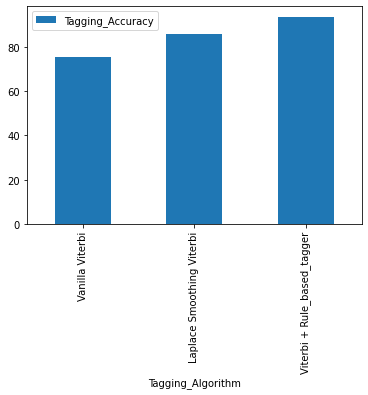

In [59]:
sample_test_data_acccuracy_df.plot.bar()

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [49]:
# test sentences

test_sentence_1 = 'Android is a mobile operating system developed by Google.'
test_sentence_2 = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
test_sentence_3 = "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose."
test_sentence_4 = 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.'
test_sentence_5 = 'Before entering politics, Donald Trump was a domineering businessman and a television personality.'
test_sentence_6 = 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.'
test_sentence_7 = 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.'
test_sentence_8 = 'Show me the cheapest round trips from Dallas to Atlanta'
test_sentence_9 = 'I would like to see flights from Denver to Philadelphia.'
test_sentence_10 = 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.'
test_sentence_11 = 'NASA invited social media users to experience the launch of ICESAT-2 Satellite.'

# Case - 1

In [60]:
# test_sentence_1 = 'Android is a mobile operating system developed by Google.'

words_test_sentence_1 = nltk.word_tokenize(test_sentence_1)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi = Vanilla_Viterbi(words_test_sentence_1)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_Laplace_viterbi = Viterbi_with_Laplace_Smoothing(words_test_sentence_1)


# pos tags with rule based viterbi tagger
pos_tagged_sequence_with_viterbi_rule_based = viterbi_rule_based_tagger(words_test_sentence_1)

In [63]:
cols = ['vanilla_viterbi_tags', 'viterbi_rule_based_tags_with_corrections']
tags_correction_df_1 = pd.DataFrame(columns = cols)
tags_correction_df_1 = tags_correction_df_1.fillna(0)

tags_correction_df_1['vanilla_viterbi_tags'] = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi]
tags_correction_df_1['laplace_viterbi_tags'] = [tup for tup in pos_tagged_sequence_with_Laplace_viterbi]
tags_correction_df_1['viterbi_rule_based_tags_with_corrections'] = [tup for tup in pos_tagged_sequence_with_viterbi_rule_based]

tags_correction_df_1

,vanilla_viterbi_tags,viterbi_rule_based_tags_with_corrections,laplace_viterbi_tags
0,"(Android, CONJ)","(Android, NOUN)","(Android, NOUN)"
1,"(is, VERB)","(is, VERB)","(is, VERB)"
2,"(a, DET)","(a, DET)","(a, DET)"
3,"(mobile, ADJ)","(mobile, ADJ)","(mobile, ADJ)"
4,"(operating, NOUN)","(operating, NOUN)","(operating, NOUN)"
5,"(system, NOUN)","(system, NOUN)","(system, NOUN)"
6,"(developed, VERB)","(developed, VERB)","(developed, VERB)"
7,"(by, ADP)","(by, ADP)","(by, ADP)"
8,"(Google, CONJ)","(Google, NOUN)","(Google, DET)"
9,"(., .)","(., .)","(., .)"


#### As we see above in the sample test sentence 1 the word 'Android' was tagged as 'CONJ' and 'Google' as CONJ by vanilla viterbi. The rule based viterbi algorithm corrected this and tagged 'Android' and 'Google' as NOUN. But Laplace smoothing tagger fixed Android but wrongly changed pos tag of 'Google' to 'DET'. So, Rule based tagger is clear winner in this case.

# Case - 2

In [64]:
# test_sentence_6 = 'The 2018 FIFA World Cup is the 21st FIFA World Cup, 
#                   an international football tournament contested once every four years.'

words_test_sentence_6 = nltk.word_tokenize(test_sentence_6)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi_6 = Vanilla_Viterbi(words_test_sentence_6)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_Laplace_viterbi_6 = Viterbi_with_Laplace_Smoothing(words_test_sentence_6)

# pos tags with rule based viterbi tagger
pos_tagged_sequence_with_viterbi_rule_based_6 = viterbi_rule_based_tagger(words_test_sentence_6)

In [65]:
tags_correction_df_6 = pd.DataFrame(columns = cols)
tags_correction_df_6 = tags_correction_df_6.fillna(0)

tags_correction_df_6.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi_6]
tags_correction_df_6['laplace_viterbi_tags'] = [tup for tup in pos_tagged_sequence_with_Laplace_viterbi_6]
tags_correction_df_6.viterbi_rule_based_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_rule_based_6]

tags_correction_df_6

,vanilla_viterbi_tags,viterbi_rule_based_tags_with_corrections,laplace_viterbi_tags
0,"(The, DET)","(The, DET)","(The, DET)"
1,"(2018, CONJ)","(2018, NUM)","(2018, NOUN)"
2,"(FIFA, CONJ)","(FIFA, NOUN)","(FIFA, NOUN)"
3,"(World, NOUN)","(World, NOUN)","(World, NOUN)"
4,"(Cup, CONJ)","(Cup, NOUN)","(Cup, NOUN)"
5,"(is, VERB)","(is, VERB)","(is, VERB)"
6,"(the, DET)","(the, DET)","(the, DET)"
7,"(21st, CONJ)","(21st, NUM)","(21st, NOUN)"
8,"(FIFA, CONJ)","(FIFA, NOUN)","(FIFA, NOUN)"
9,"(World, NOUN)","(World, NOUN)","(World, NOUN)"


#### As we see above in the sample test sentence 6 the following words were incorrectly tagged by the vanilla viterbi algorithm -  '2018' - 'CONJ', 'FIFA' - 'CONJ', 'Cup' - 'CONJ', '21st' - 'CONJ', 'tournament' - 'CONJ', 'contested' - 'CONJ'.

#### The above words were corrected by rule based viterbi tagger. The corrections were made as - '2018' - NUM, 'FIFA' - NOUN, 'Cup' - NOUN, '21st' - NUM, 'tournament' - NOUN, 'contested' - VERB.

#### Laplace smoothing Viterbi predict '2018' as NOUN instead of 'NUM' which is wrong.

#### So, the Rule based Viterbi algorithm clearly outperformed both Vanilla and Laplace Smoothing Viterbi in case 2.

# Case - 3

In [77]:
#test_sentence_11 = 'NASA invited social media users to experience the launch of ICESAT-2 Satellite.'
words_test_sentence_11 = nltk.word_tokenize(test_sentence_11)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi_11= Vanilla_Viterbi(words_test_sentence_11)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_Laplace_viterbi_11 = Viterbi_with_Laplace_Smoothing(words_test_sentence_11)

# pos tags with rule based viterbi tagger
pos_tagged_sequence_with_viterbi_rule_based_11 = viterbi_rule_based_tagger(words_test_sentence_11)

In [78]:
tags_correction_df_11 = pd.DataFrame(columns = cols)
tags_correction_df_11 = tags_correction_df_11.fillna(0)

tags_correction_df_11.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi_11]
tags_correction_df_11['laplace_viterbi_tags'] = [tup for tup in pos_tagged_sequence_with_Laplace_viterbi_11]
tags_correction_df_11.viterbi_rule_based_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_rule_based_11]

tags_correction_df_11

,vanilla_viterbi_tags,viterbi_rule_based_tags_with_corrections,laplace_viterbi_tags
0,"(NASA, CONJ)","(NASA, NOUN)","(NASA, NOUN)"
1,"(invited, CONJ)","(invited, VERB)","(invited, NOUN)"
2,"(social, ADJ)","(social, ADJ)","(social, ADJ)"
3,"(media, NOUN)","(media, NOUN)","(media, NOUN)"
4,"(users, NOUN)","(users, NOUN)","(users, NOUN)"
5,"(to, PRT)","(to, PRT)","(to, PRT)"
6,"(experience, NOUN)","(experience, NOUN)","(experience, NOUN)"
7,"(the, DET)","(the, DET)","(the, DET)"
8,"(launch, NOUN)","(launch, NOUN)","(launch, NOUN)"
9,"(of, ADP)","(of, ADP)","(of, ADP)"


#### As we see in the sample test sentence 11, the vanilla viterbi tagged 'NASA', 'invited', 'ICESAT-2', 'Satellite' as 'CONJ'. This was corrected by the rule based viterbi tagger perfectly with tagging 'NASA' as NOUN, 'invited' as VERB, 'ICESAT-2' as NOUN and 'Satellite' as NOUN. Whereas, the Laplace Smoothing Viterbi wrongly predicted (invited as NOUN) and (ICESAT-2 as DET).

#### So in case 3, sentence 11, Rule based Viterbi tagger again came out to be the clear winner.

# Conclusion - 

   ### Accuracies of Viterbi variants on 5% Test set:-
   
       1. Vanilla Viterbi tagger 91.13%
       2. Laplace Smoothing Viterbi tagger :- 94.25%
       3. Rule based Viterbi tagger:- 95.87%
       
   #### Rule Based Viterbi tagger has come out to be the clear winner here. It gave 95.87% accuracy on the 5% test set.
   
   ### Accuracies of Viterbi variants on Test sentences provided in the problem statement:-
   
       1. Vanilla Viterbi tagger 75.69%
       2. Laplace Smoothing Viterbi tagger :- 86.18%
       3. Rule based Viterbi tagger:- 93.92%
       
   #### Rule Based Viterbi tagger has come out to be the clear winner here again with highest accuracy of 93.92%.

   We saw that Rule based viterbi tagger fixed all the tags wrongly predicted by the Vanilla Viterbi tagger on the 3 test sentences we selected, so, the final winner variant of the Viterbi algorithm is Rule Based Viterbi Tagger in which we defined **Morphological derivation rules**  for predicting unkown words specifically and the rest of the words are predicted by probabilistic HMM + Viterbi model. 
 	